In [122]:
#!pip install seaborn
#!pip install scikit-learn

In [1]:
# Imports
import numpy as np      
import pandas as pd 

# To plot
import matplotlib.pyplot as plt  
import seaborn as sns

# Models and statistics
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller #adf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 

import warnings
warnings.filterwarnings("ignore")

# print in markdown
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

### Dataset

    The growth of supermarkets in most populated cities are increasing and market competitions are also high. The dataset is one of the historical sales of supermarket company which has recorded in 3 different branches for 3 months data. 

    Predictive data analytics methods are easy to apply with this dataset.

In [2]:
df = pd.read_excel("Superstore.xls")
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


### Columns:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

### Possible values for Country, Region, Category, and SubCategories

    COUNTRY
    - 'United States'
    
    REGION
    - 'South', 'West', 'Central', 'East'
    
    CATEGORY
    - 'Furniture', 'Office Supplies', 'Technology'
    
    SUB CATEGORIES
    - Furniture
        -  Bookcases, Chairs, Tables, Furnishings
    - Office Supplies
        - Labels, Storage, Art, Binders, Appliances, Paper, Envelopes, Fasteners, Supplies
    - Technology
        - Phones, Accessories, Machines, Copiers

In [4]:
# print(df["Country"].unique(), "\n")
# print(df["Region"].unique(), "\n")
# print(df["Category"].unique(), "\n")
# print(df.groupby(["Category"])["Sub-Category"].unique())

### Pairplot between numeric variables 

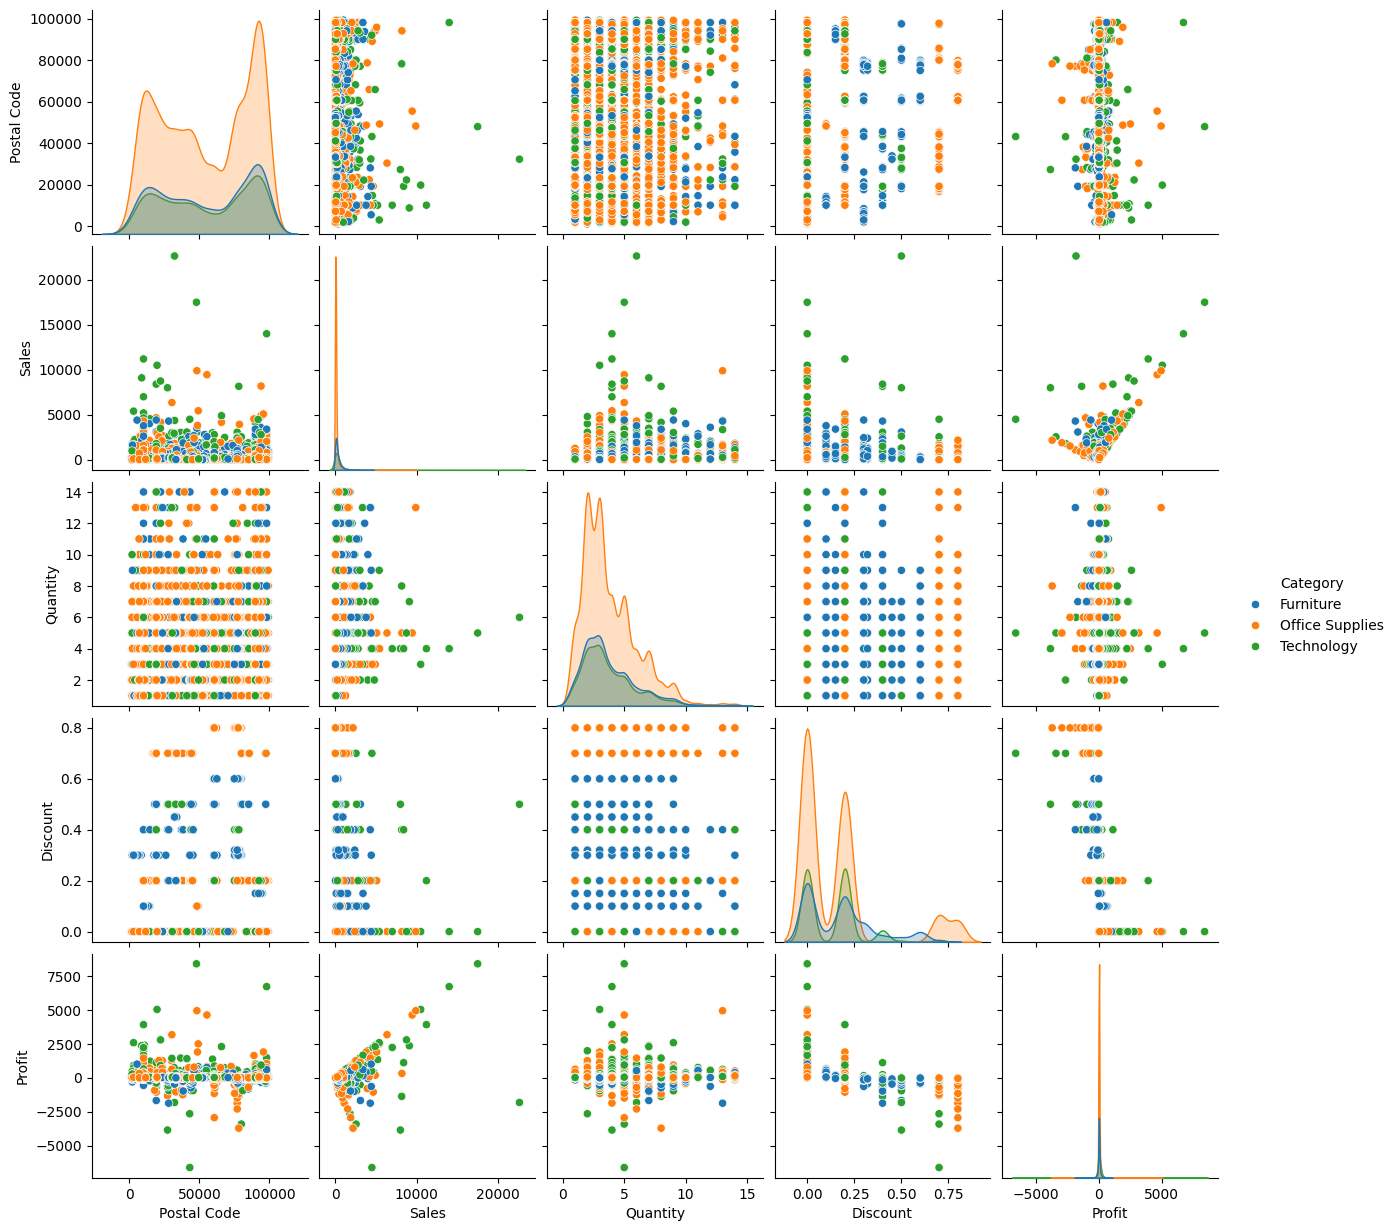

In [5]:
df = df.drop(["Row ID", "Order ID", "Customer ID", "Customer Name", "Product ID", "Product Name"], axis=1)
sns.pairplot(df, hue="Category")

### Looking for correlation between numeric variables

    There is no strong correlation between the numerical variables.

In [6]:
df_float = df[["Postal Code", "Sales", "Quantity", "Discount", "Profit"]]
df_float.corr()

,Postal Code,Sales,Quantity,Discount,Profit
Postal Code,1.000000,-0.023854,0.012761,0.058443,-0.029961
Sales,-0.023854,1.000000,0.200795,-0.028190,0.479064
Quantity,0.012761,0.200795,1.000000,0.008623,0.066253
Discount,0.058443,-0.028190,0.008623,1.000000,-0.219487
Profit,-0.029961,0.479064,0.066253,-0.219487,1.000000


### Exploring Categories

    The most sold products correspond to the Category 'Office Supplies', followed by Furniture, and last Technology.

<Axes: xlabel='Category', ylabel='Count'>

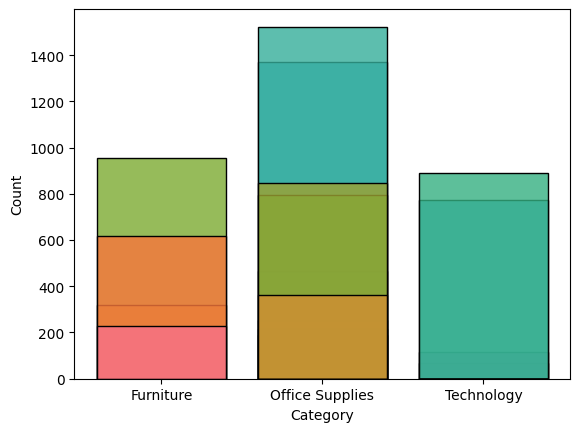

In [7]:
sns.histplot(data=df, x="Category", hue="Sub-Category", shrink=.8, alpha=.8, legend=False)

### Details for Sub-Categories

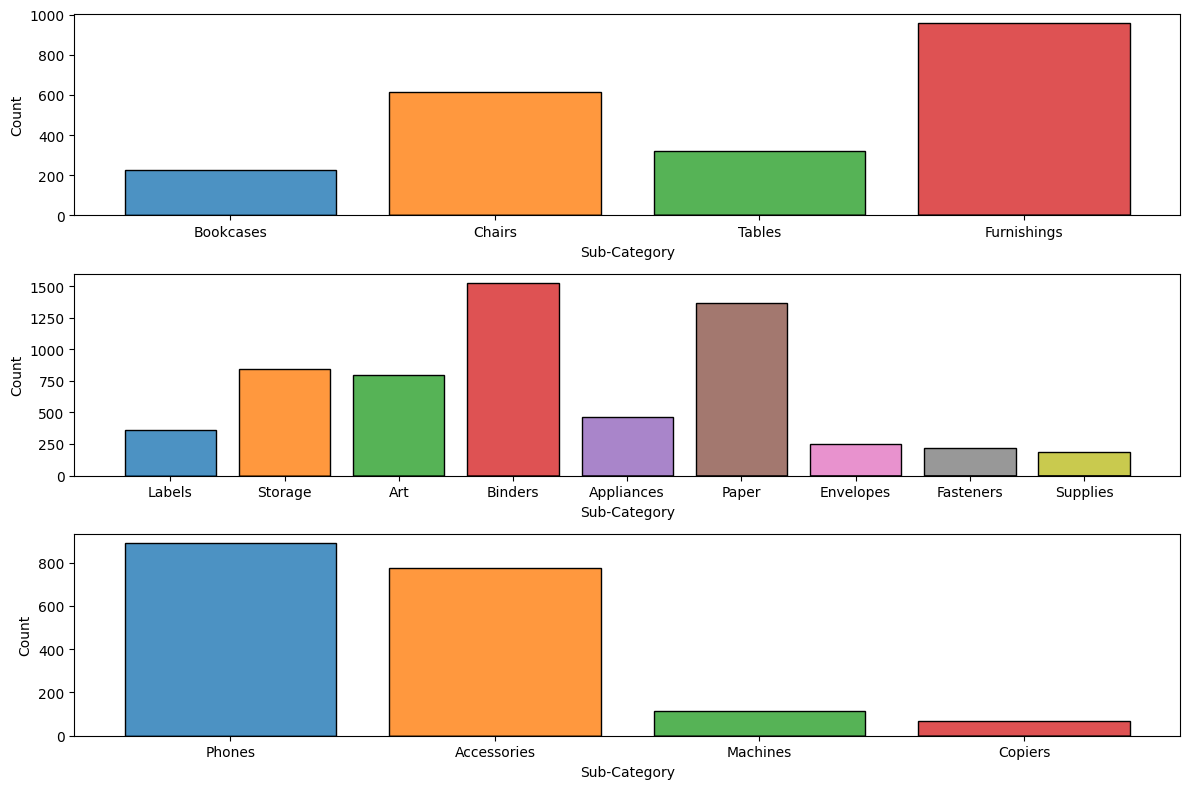

In [8]:
"""
Categories
['Furniture' 'Office Supplies' 'Technology'] 
"""
df_furniture = df[df["Category"]=="Furniture"]
df_office_supplies = df[df["Category"]=="Office Supplies"]
df_technology = df[df["Category"]=="Technology"]

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
sns.histplot(data=df_furniture, x="Sub-Category", hue="Sub-Category", shrink=.8, alpha=.8, legend=False, ax=axes[0])
sns.histplot(data=df_office_supplies, x="Sub-Category", hue="Sub-Category", shrink=.8, alpha=.8, legend=False, ax=axes[1])
sns.histplot(data=df_technology, x="Sub-Category", hue="Sub-Category", shrink=.8, alpha=.8, legend=False, ax=axes[2])
fig.tight_layout()

### Exploring sales for Category

    Looking the sales over time for each category, with daily data (default) and monthly data (with the sum of sales during the month).

<Axes: xlabel='Order Date', ylabel='Sales'>

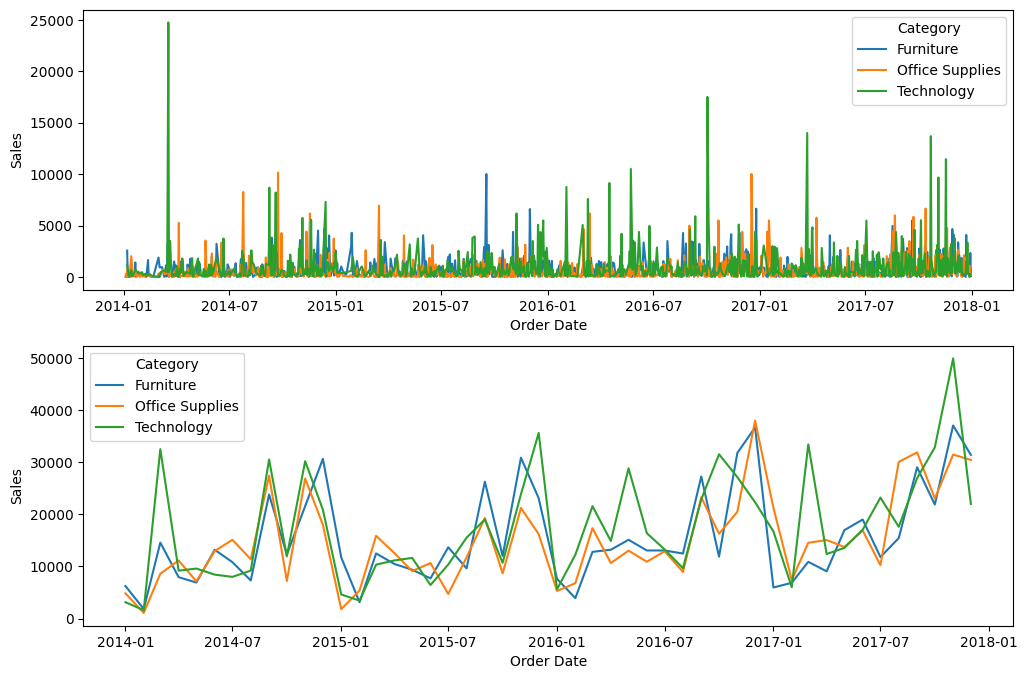

In [9]:
df_total_cat = df[['Order Date', 'Sales', 'Category']]

# Set 'Order Date' as the index
df_total_cat.set_index('Order Date', inplace=True)

# Use resample to aggregate the sales on a daily basis while keeping the 'Category'
df_total_daily_cat = df_total_cat.groupby(['Category', pd.Grouper(freq='D')]).sum().reset_index()
df_total_monthly_cat = df_total_cat.groupby(['Category', pd.Grouper(freq='MS')]).sum().reset_index()

# Display the resulting DataFrame
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sns.lineplot(data=df_total_daily_cat, x='Order Date', y='Sales', hue='Category', ax=axes[0])
sns.lineplot(data=df_total_monthly_cat, x='Order Date', y='Sales', hue='Category', ax=axes[1])

### Defining dataframes for daily and monthly sales

    The analysis with explore the decomposition of both time series. This separates:
    - trend: long term behaviour or changes of time series data.
    - seasonality: regular predictable behaviour between similar periods of time.
    - noise/residual: what remains of the time series after the trend and seasonality are removed.
    
    The additive decomposition is:
    
    xt = Trend + Seasonal + Random

In [10]:
"""
allows to see 
- observed values
- general trend
- seasonal values of the data
- residual from seasonal => noisy values
"""

df_total = df[['Order Date', 'Sales']]
df_total.set_index('Order Date', inplace=True)

df_total_daily = df_total.resample('D').sum()
df_total_monthly = df_total.resample('MS').sum()

In [11]:
def create_figure():
    fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))

    axes[0,0].title.set_text('Daily time series')
    axes[0,1].title.set_text('Monthly time series')
    
    axes[0,0].set_ylabel('Observed')
    axes[1,0].set_ylabel('Trend')
    axes[2,0].set_ylabel('Seasonal')
    axes[3,0].set_ylabel('Resid')

    return fig, axes
    
def plotting_aux(decomposition, axes, param): 
    decomposition.observed.plot(ax=axes[0,param])
    decomposition.trend.plot(ax=axes[1,param])
    decomposition.seasonal.plot(ax=axes[2,param])
    decomposition.resid.plot(ax=axes[3,param])

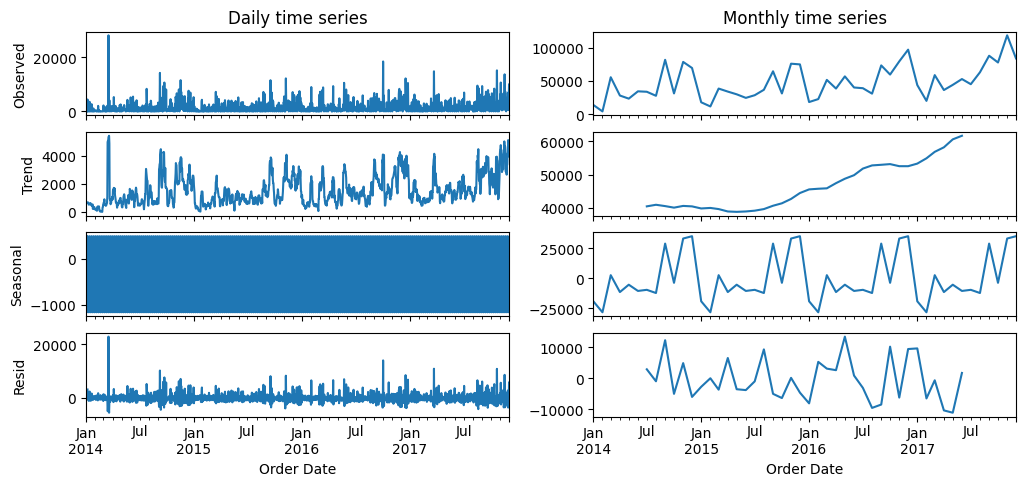

In [12]:
"""
ADDITIVE SEASONAL DECOMPOSE DAILY AND MONTHLY
"""
decomposition_daily = seasonal_decompose(df_total_daily, model='additive')
decomposition_monthly = seasonal_decompose(df_total_monthly, model='additive')

fig, axes = create_figure()
plotting_aux(decomposition_daily, axes, 0)
plotting_aux(decomposition_monthly, axes, 1)

plt.show()

### Multiplicative/additive decomposition vs STL
    
    Multiplicative/additive decomposition has the following disadvantages:
    - it assumes fixed seasonal periods
    - it assumes the seasonal component to be constant
    - it assumes the trend to be linear
    - also if the dataset has multiple seasonal patterns the additive/multiplicative method may not produce accurate results.
    
    To overcome the shortcomings of the classical additive/multiplicative decomposition method, “STL: Seasonal-Trend Decomposition Procedure Based on Loess” was introduced. 
    
    This method can handle any type of seasonality and we can also control the rate of change of the seasonal component to better match 
    the seasonal characteristics of our data.

### STL

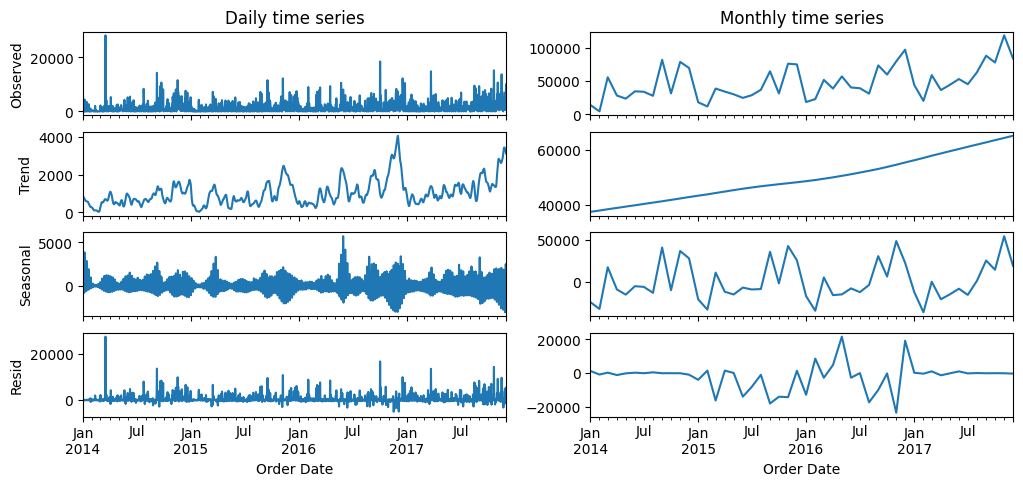

In [13]:
# Set robust to True to handle outliers
stl_daily = STL(df_total_daily["Sales"], robust=True).fit() 
stl_monthly = STL(df_total_monthly["Sales"], robust=True).fit() 

fig, axes = create_figure()
plotting_aux(stl_daily, axes, 0)
plotting_aux(stl_monthly, axes, 1)
plt.show()

### STATIONARITY 

    A stationary time series is a series which has **constant statistical** properties (such as trend, seasonality and covariance) and **do not 
    change over time**. 
    - should have a constant mean and standard deviation.

### WHY STATIONARY TIME SERIES

    If a time series is stationary, this means that the patterns and trends in the time series are consistent over time, and are not influenced by external factors.
    
    A non-stationary time series is one in which the statistical properties are not constant over time, and may be influenced by external factors such as seasonality or trends. 
    - Non-stationary time series can be more difficult to analyze and forecast, as the patterns and trends may change over time.
    
    There are several reasons why it is important to determine whether a time series is stationary or not:
    
    - Statistical analysis: Many statistical techniques and models, such as linear regression and time series forecasting, assume that the data is stationary. If the data is non-stationary, these techniques may not be reliable or may produce misleading results.
    
    - Forecasting: Forecasting techniques often rely on the assumption that the patterns and trends in the data are consistent over time. If the data is non-stationary, it may be difficult to make accurate predictions about future outcomes.
    
    - Data preprocessing: Many time series analysis techniques, such as differencing and detrending, are used to transform non-stationary time series data into stationary data. Knowing whether a time series is stationary or not can inform the choice of data preprocessing techniques to use.

### DETERMINING IF A TIME SERIES IS STATIONARY

    This can be done using the Augmented Dickey-Fuller Test (ADF), this test is a unit root test for stationarity. 
    
    A unit root process is a data-generating process whose first difference is stationary. 
    
    The first difference of a time series is the series of changes from one period to the next. If Yt denotes the value of the time series Y at period t, then the first difference of Y at period t is equal to Yt-Y(t-1).

In [14]:
def print_adfuller(df):
    result = adfuller(df)
    
    print(f'Critical value of the data: {result[0]}')
    print(f'P-value: {result[1]}')
    print(f'Number of lags: {result[2]}')
    print(f'Number of observations used in the analysis: {result[3]}\n')
        
    if result[1] < 0.05:
        printmd("P-value is less than the significance level of 0.05. We reject the null hyphotesis, and take that the series **IS STATIONARY**.")
    else:
        printmd("P-value is equal or more than the significance level of 0.05. We accept the null hyphotesis, and take that the series **IS NON-STATIONARY**.")
   
    # for key, value in result[4].items():
    #     print('Critial Values [t-values corresponding to adfuller test] :')
    #     print(f'\t{key}, {value}')    

printmd("#### DAILY DATA STATIONARITY")
print_adfuller(df_total_daily)

printmd("#### MONTHLY DATA STATIONARITY")
print_adfuller(df_total_monthly)

#### DAILY DATA STATIONARITY

Critical value of the data: -4.9398788035313235
P-value: 2.914879072767256e-05
Number of lags: 20
Number of observations used in the analysis: 1437



P-value is less than the significance level of 0.05. We reject the null hyphotesis, and take that the series **IS STATIONARY**.

#### MONTHLY DATA STATIONARITY

Critical value of the data: -4.493767844002667
P-value: 0.00020180198458237607
Number of lags: 0
Number of observations used in the analysis: 47



P-value is less than the significance level of 0.05. We reject the null hyphotesis, and take that the series **IS STATIONARY**.

### AUTOCORRELATION PLOT - ACF    

    An autocorrelation plot, also known as an ACF (AutoCorrelation Function) plot, is a graphical tool used to visualize the autocorrelation function of a time series. 
    The autocorrelation function measures the correlation between a time series and a lagged version of itself at different time lags. 
    Autocorrelation plots help you identify patterns and trends in the correlation structure of the data.
    
    Interpretation:
    - If autocorrelation at lag 1 is high, it suggests that there is a strong correlation between consecutive observations.
    - If autocorrelation at higher lags is significant, it may suggest the presence of a seasonal pattern.
    - If autocorrelation at lag 0 is significant, it indicates a strong correlation with itself, suggesting the presence of a trend.
    
    Decay over time: Ideally, autocorrelation values should decay as the lag increases. A rapid decay suggests that the series is stationary.
    
    Here's an example interpretation:
    
    If you see a spike in autocorrelation at a lag of 7, it might indicate a weekly pattern, suggesting that the time series exhibits a repeating pattern every 7 time units (days, weeks, etc.).

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

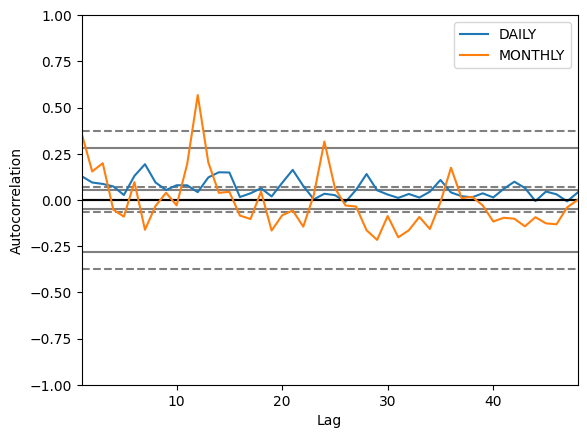

In [15]:
pd.plotting.autocorrelation_plot(df_total_daily, label="DAILY")
pd.plotting.autocorrelation_plot(df_total_monthly, label="MONTHLY")

    From the plot, we can observed the strong autocorrelation in:
    - lag 7 for the daily data (weekly seasonality)
    - lag 12 for monthly data (anual seasonality)
    
    We also observe that there is a decay over time. We already establish that both time series are stationary

### Autocorrelation Function (ACF):

    - Identifying Autocorrelation:
        ACF plots display the correlation between a time series and its lagged values. Peaks in the ACF plot indicate the presence of autocorrelation at specific lags.

    - Seasonality Detection:
        Significant spikes at regular intervals suggest seasonality in the data. This helps identify repeating patterns and cycles.

    - Model Order Selection (AR and MA):
        ACF plots assist in determining the order of autoregressive (AR) and moving average (MA) components in ARIMA and SARIMA models. The lag at which ACF cuts off can suggest the order of the MA component.

    - Differencing Guidance:
        ACF plots help identify the need for differencing. If there is a slow decay in autocorrelations, it may indicate non-stationarity and the need for differencing.

### Partial Autocorrelation Function (PACF):

    - Direct Relationship with Lag:
        PACF plots show the partial correlation between a time series and its lagged values, controlling for the effect of intermediate lags.

    - Model Order Selection (AR):
        PACF plots are crucial for determining the order of the autoregressive (AR) component in ARIMA and SARIMA models. The partial autocorrelation at a given lag helps identify the order of the AR component.

    - Differencing Guidance:
        PACF plots also aid in identifying the need for differencing. A spike at lag 1 in the PACF may indicate the need for first-order differencing.

### Overall Importance:

    - Model Specification:
        ACF and PACF plots guide the specification of autoregressive, moving average, and differencing orders in time series models. Proper model specification is crucial for accurate forecasts.

    - Diagnosis of Time Series Behavior:
        ACF and PACF plots help diagnose the behavior of a time series. They provide insights into the presence of trends, seasonality, and other patterns.

    - Model Evaluation:
        When building time series models, ACF and PACF plots are used iteratively to evaluate model fit. Deviations from expected patterns in the residuals can be identified.

    - Forecasting Performance:
        A well-specified model based on ACF and PACF analysis is likely to result in better forecasting performance.

### DAILY DATA ACF AND PACF PLOTS

    Since we have peaks outside the threshold, meaning lags that are statistically significant, we can ensure that we do not have white noise data/random data.
    
    For daily data, we can observe a peak/strong correlation (in both plots) at:
    - lag 0 => strong correlation with itself, then it suggest the precense of a trend.
    - lag 7/14/21 decreasing => suggets weekly seasonality.

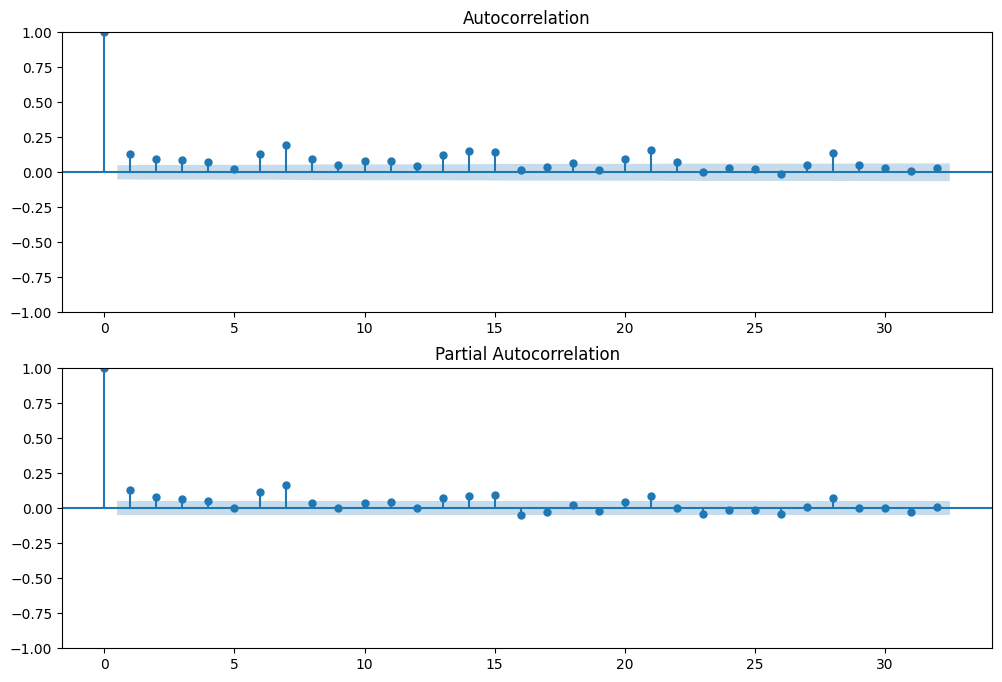

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df_total_daily, ax=axes[0]) # correlation between y and y-7
plot_pacf(df_total_daily, ax=axes[1])

plt.show()

# DAILY DATA FORECASTING

    We will first work with daily data. Now we already analyze stationality and ACF/PACF plots, we will apply different models to try getting the best forecasting for this data. We will later replicate the models for monthly data.

### AUTO REGRESSION

    Is one of the main components of a time series model. Essencially predicting a current value based on the past values. 
    Creates a linear regression model based on the past values.
    
    An autoregression order refers to the number of past terms multiplied by coefficients. An error term is added to the equation in order
    to account for white noise.
    
    Is generally fit with our data. Uses previous lags. Lags are an incremental time difference between two points.
    In our case, each lag is a day.

In [17]:
def model1_autoregression(df, lags, lags_to_predict):
    #train, test = train_test_split(df, test_size=0.3, shuffle=False)
    train, test = df[1:len(df)-lags_to_predict], df[len(df)-lags_to_predict:] 

    # train autoregression
    model = AutoReg(train, lags=lags)
    model_fit = model.fit()
    # print('Coefficients: %s' % model_fit.params)

    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    rmse = math.sqrt(mean_squared_error(test, predictions))
    print('\nRMSE: %.3f' % rmse)

    # return model_fit, predictions
    return model_fit, predictions

def plot_prediction(df, prediction):
    ax = df.plot()
    predictions.plot(ax=ax, alpha=.7, figsize=(14, 7))
    ax.legend(["Observed", "Predicted"]);
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily sales')
    plt.show()


RMSE: 1709.848


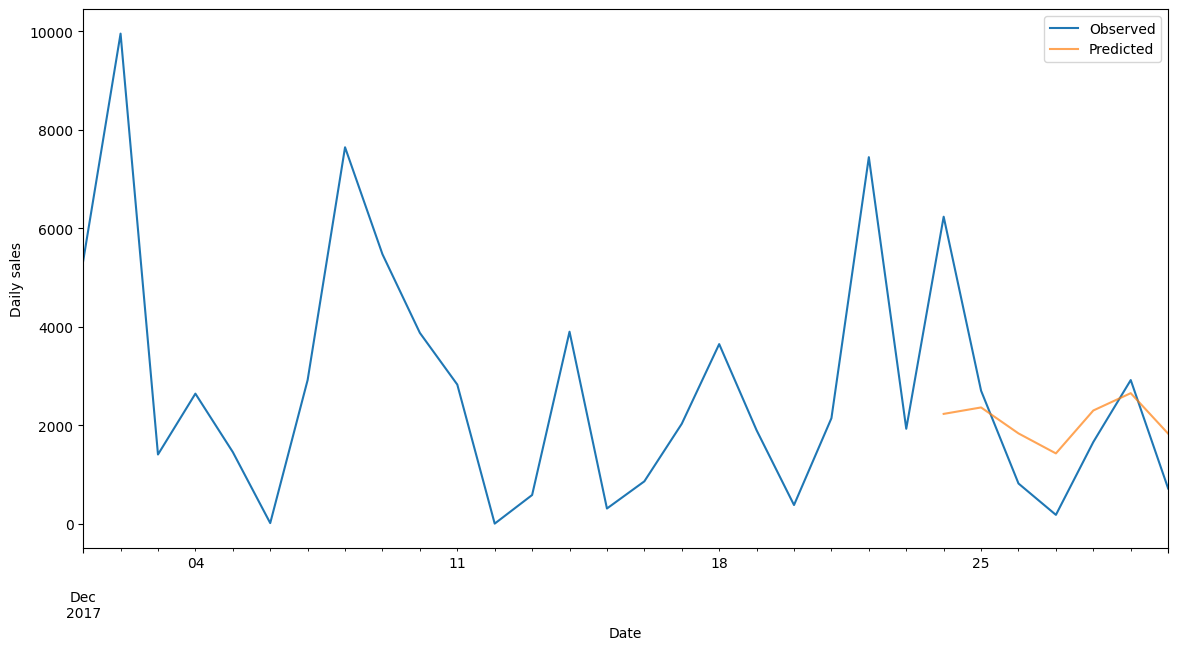

In [18]:
# daily data, lags=7 for autoregression model, 
model_fit, predictions = model1_autoregression(df_total_daily, 7, 7)
plot_prediction(df=df_total_daily["2017-12-01":], prediction=predictions)

### ARIMA MODEL
    
    Autoregressive integrated moving average (ARIMA) models predict future values based on past values. ARIMA makes use of lagged moving averages to smooth time series data. They are widely used in technical analysis to forecast future security prices.
    
    Choosing the values for the order parameters (p, d, q) in an ARIMA model can be done through a process of model selection and evaluation. The order parameters represent the autoregressive order (p), the differencing order (d), and the moving average order (q) in the ARIMA model, respectively.

    d is defined by the number of time differencing is necessary, in our case 0 => because our time series is already stationary
    p the number of observations of the model - lag order, AR defined by PACF plot
    q the size of the moving average window - MA order of the moving average ACF
    
     AR      I      MA
    pacf    diff.  acf

    We can define the AR and MA orders looking into the ACF and PACF plots. In the case of daily data, our values are 7. The value of I, is 0.

In [19]:
def model2_arima(model, df, from_date):
    predictions = model_fit.get_prediction(start=pd.to_datetime(from_date), dynamic=False)
    y = df[from_date:]["Sales"].values
    
    # Report Performance
    print("Performance:")
    mse = mean_squared_error(y, predictions.predicted_mean)
    print('MSE: ' + str(mse))
    mae = mean_absolute_error(y, predictions.predicted_mean)
    print('MAE: ' + str(mae))
    rmse = math.sqrt(mean_squared_error(y, predictions.predicted_mean))
    print('RMSE: ' + str(rmse))

    return predictions.predicted_mean
    
model = ARIMA(df_total_daily, order=(7,0,7))
model_fit = model.fit()

#### PLOT DIAGNOSIS

    Standardized residual for "S": indicates the raw residual divided by an estimate of the standard deviation of the residuals. It's a measure of the strength of the difference between observed and expected values.
    
    Histogram plot: shows the distribution of the residuals. The histogram shows us the measured distribution; the orange line shows a smoothed version of this histogram, and the green line shows a normal distribution. If the model is good these two lines should be the same.
    
    Normal Q–Q plot: shows the distribution of the data against the expected normal distribution. For normally distributed data, observations should lie approximately on a straight line.
    
    Correlogram: is a chart of correlation statistics. The correlogram is a commonly used tool for checking randomness in a data set. If random, autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero. 

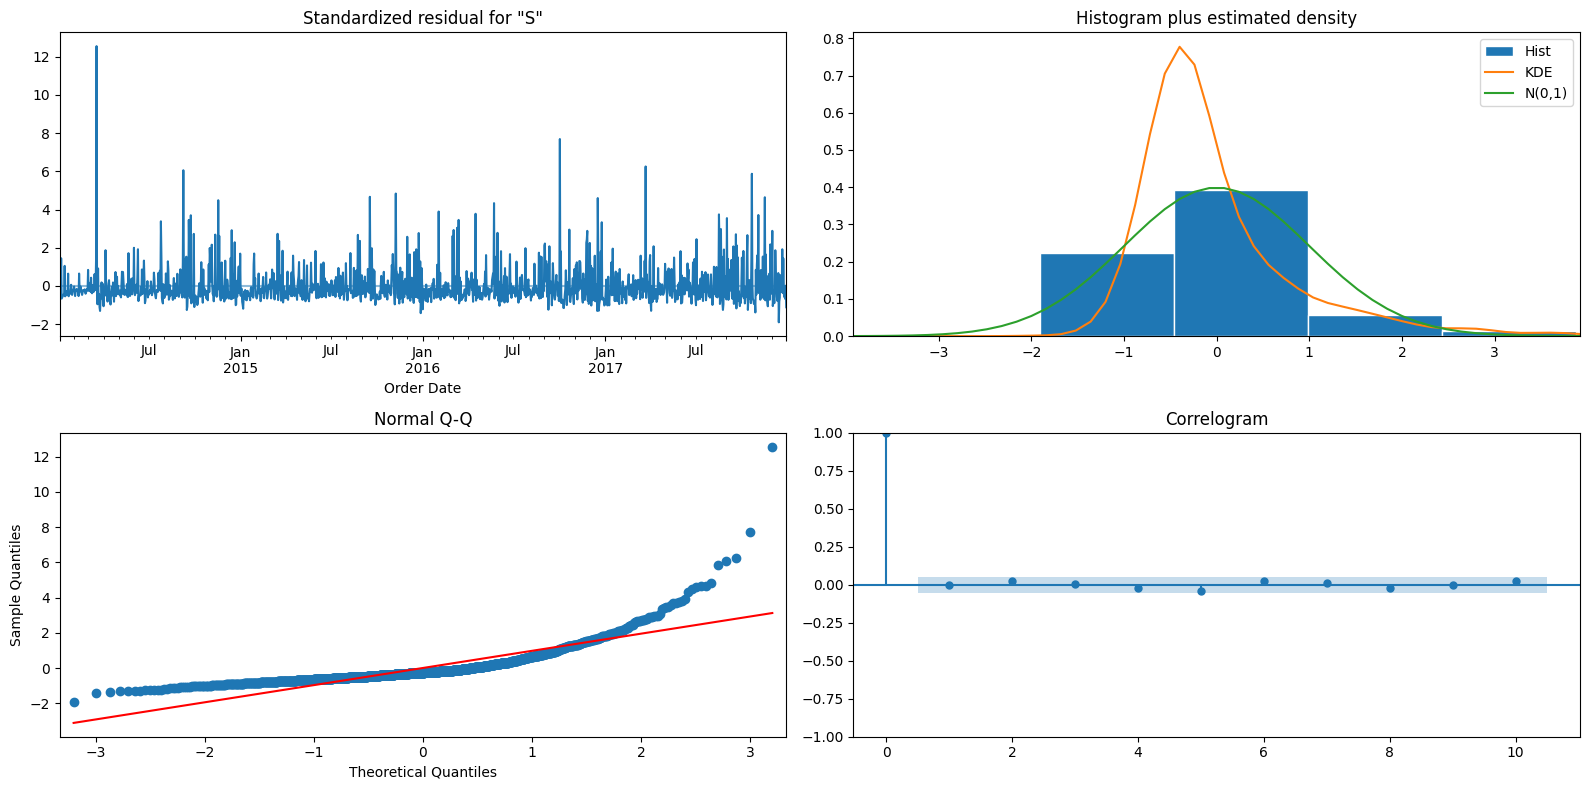

In [20]:
fig = model_fit.plot_diagnostics(figsize=(16, 8))
fig.tight_layout()
plt.show()

Performance:
MSE: 6807512.958662341
MAE: 1895.5792646215034
RMSE: 2609.1211084697356


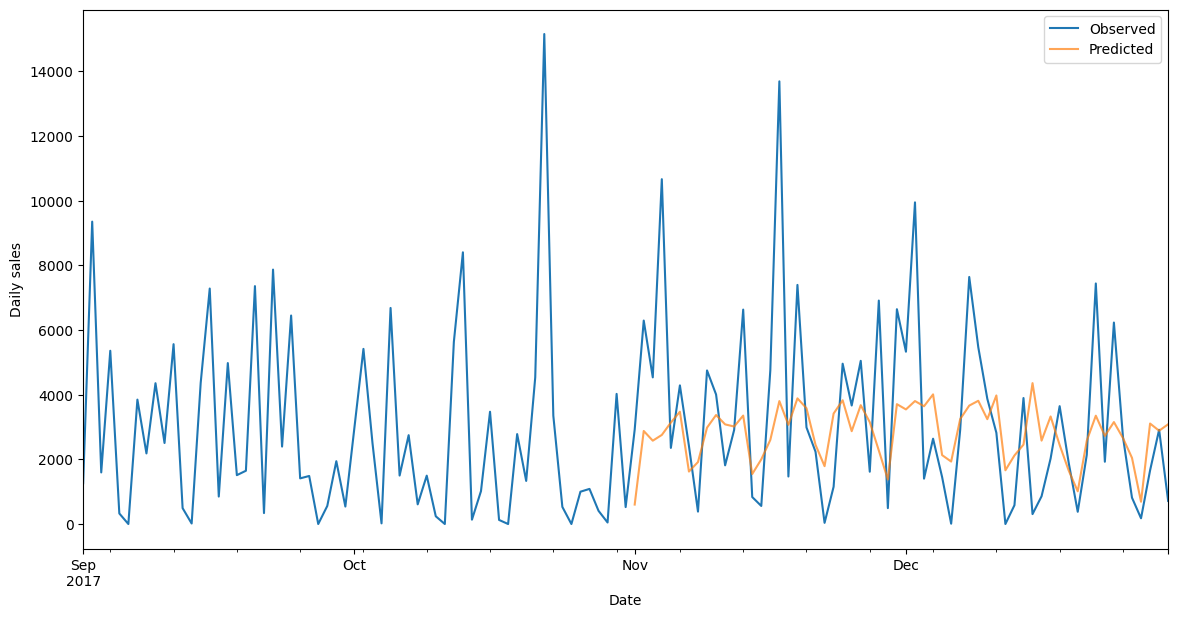

In [21]:
predictions = model2_arima(model_fit, df_total_daily, "2017-11-01")
plot_prediction(df=df_total_daily["2017-09-01":], prediction=predictions)

### SARIMA MODEL

# MONTHLY DATA FORECASTING
    Now we will focus on monthly data (sum of sales during each month).
    
### MONTHLY DATA ACF AND PACF PLOTS

    Since we have peaks outside the threshold, meaning lags that are statistically significant (1/12), we can ensure that we do not have white noise data/random data.

    For daily data, we can observe a peak/strong correlation (in both plots) at:
    - lag 0 => strong correlation with itself, then it suggest the precense of a trend.
    - lag 12 => suggets anual seasonality.

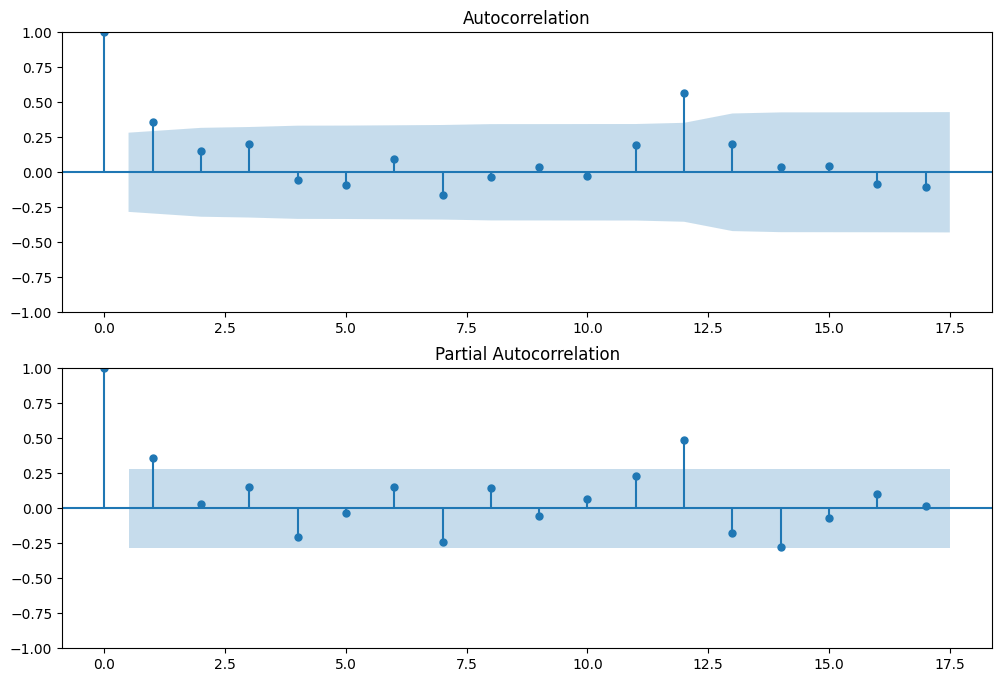

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df_total_monthly, ax=axes[0]) # correlation with y-12
plot_pacf(df_total_monthly, ax=axes[1])

plt.show()

### AUTOREGRESSION MODEL


RMSE: 20448.584


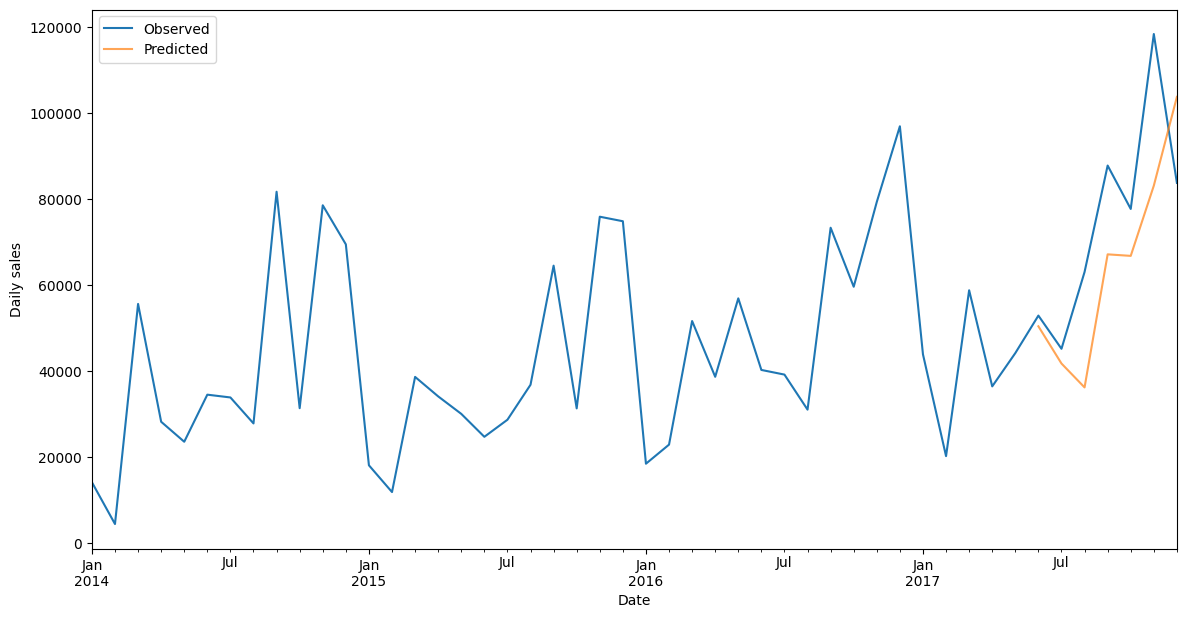

In [23]:
# monthly data, lags=12 for autoregression model, predicting last 7 months
model_fit, predictions = model1_autoregression(df_total_monthly, lags=12, lags_to_predict=7) 
plot_prediction(df=df_total_monthly, prediction=predictions)

### ARIMA MODEL

    The parameters for our monthly data, based on we can observe in the ACF/PACF plots, are:
    AR      I      MA
    pacf    diff.  acf
    
    AR = 12
    I = 0 (no diff)
    MA = 12

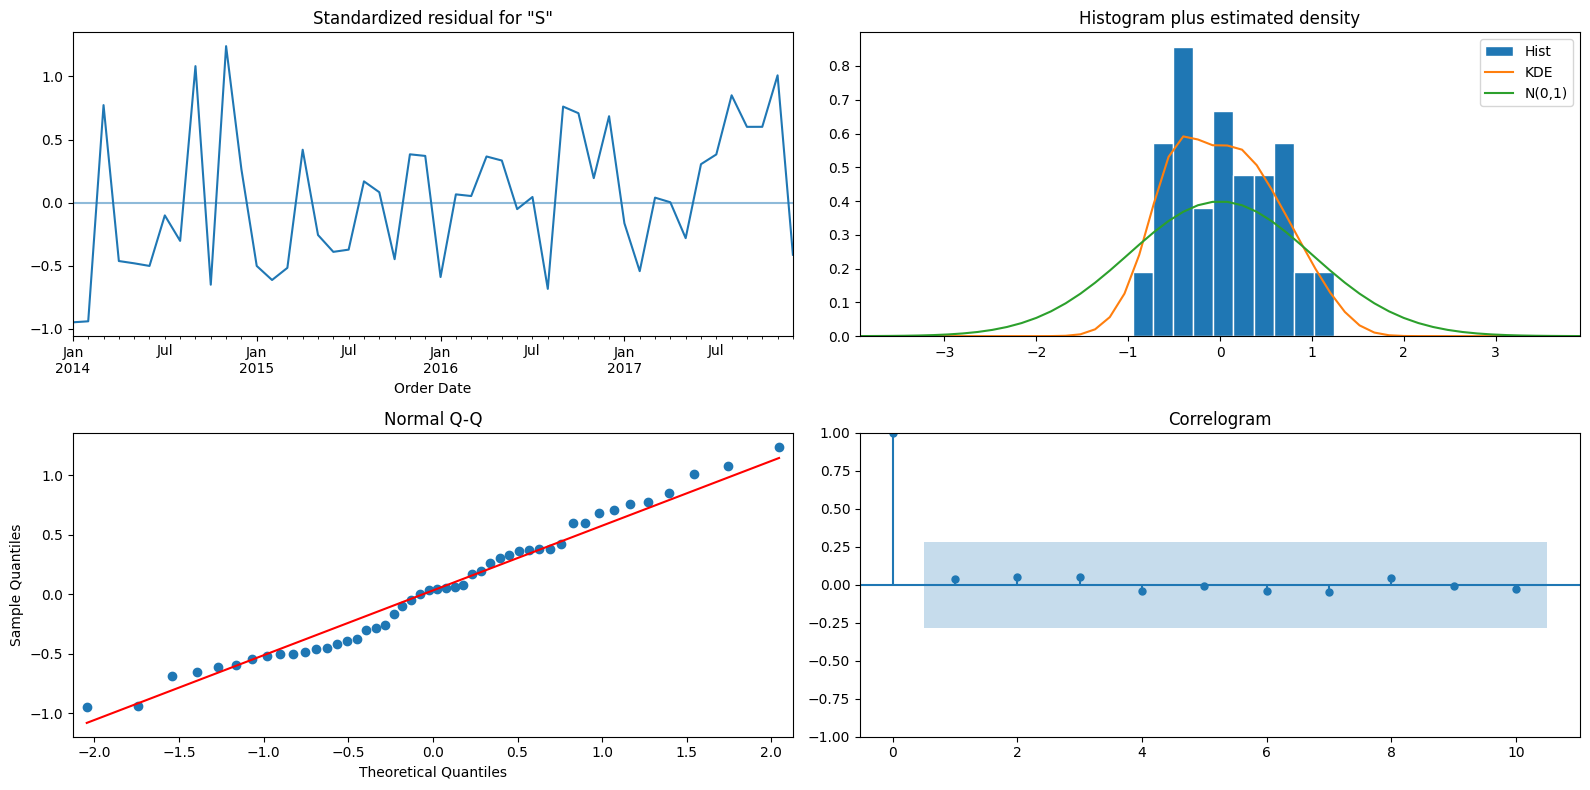

In [24]:
model = ARIMA(df_total_monthly, order=(12, 0, 12))
model_fit = model.fit()

fig = model_fit.plot_diagnostics(figsize=(16, 8))
fig.tight_layout()
plt.show()

Performance:
MSE: 255258531.02863398
MAE: 14824.531621410426
RMSE: 15976.812292464163


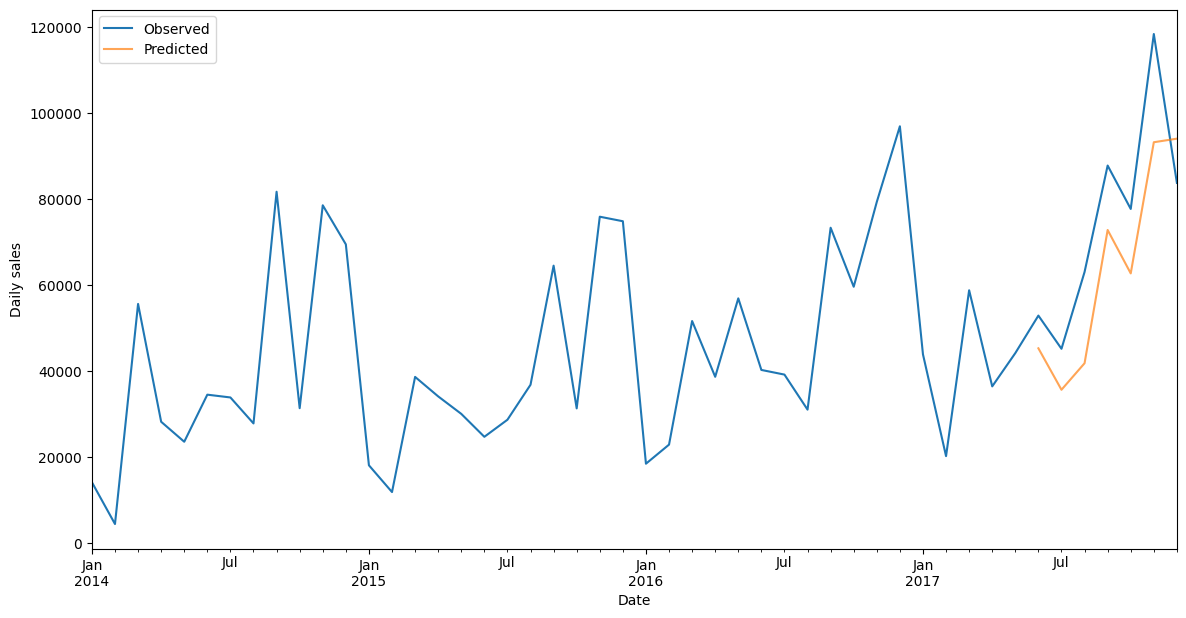

In [25]:
predictions = model2_arima(model_fit, df_total_monthly, "2017-06-01")
plot_prediction(df=df_total_monthly, prediction=predictions)